In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np


def set_random_seeds():
    my_seed = 0
    np.random.seed(my_seed)

    random.seed(my_seed)

    tf.random.set_seed(my_seed)


## 1. Looking at the data

In [156]:
# Loading the data into a Pandas dataframe
whole_dataset = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
whole_dataset.head()
whole_dataset = whole_dataset.drop(["id"], axis=1)


To see what my dataset is like and what possible challenges are in it, I make a few plots and gather some statistics.

In [157]:
# looking for missing values
for column in whole_dataset:
    if whole_dataset[column].isnull().values.any():
        amount = whole_dataset.isnull().sum().sum()
        percentage = round(
            whole_dataset.isnull().sum().sum() / len(whole_dataset[column]) * 100
        )
        print(
            f"There are {amount} missing values in the column {column}.\nThe missing values make up {percentage}% of this column"
        )


There are 201 missing values in the column bmi.
The missing values make up 4% of this column


First I look at the distribution of my data over the labels using a countplot. I do this to see if my data is evenly distributed, as the distribution of my data will affect decisions later on. 

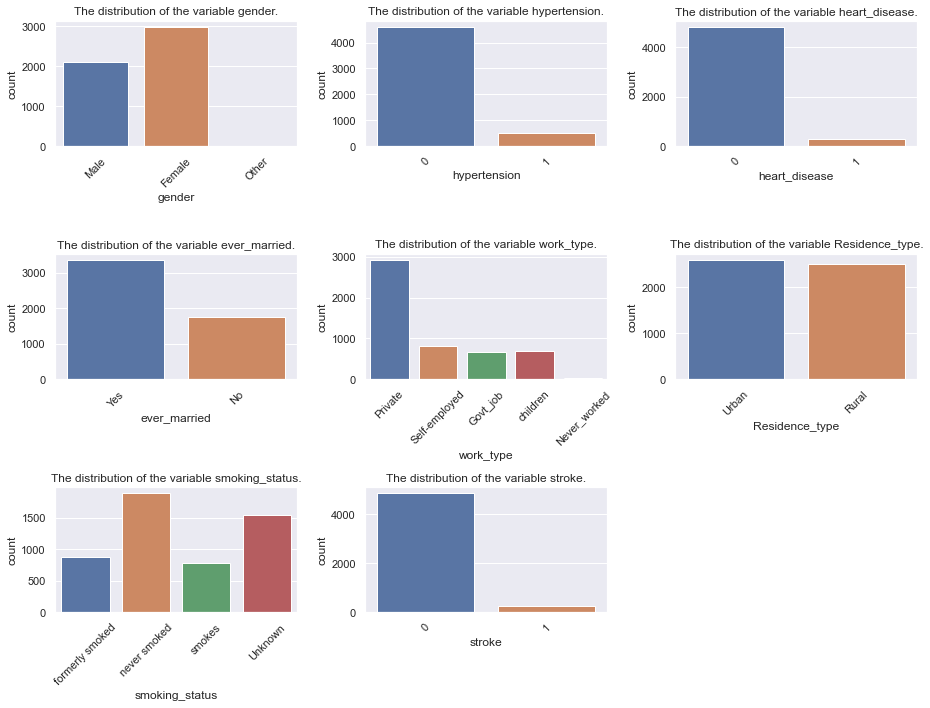

Figure 1: The distribution of the categorical variables. The x-as shows the possible options and the y-as shows how often they occur.


In [158]:
numerical = ["avg_glucose_level", "age", "bmi"]
dataset_for_viewing = whole_dataset.drop(
    numerical, axis=1
)  # These are not fit for a count plot
amount_columns = dataset_for_viewing.shape[1]
amount_plots_x_y = round(amount_columns / 2)
x = 0
y = 0
sns.set_theme(style="darkgrid")


fig, ax = plt.subplots(3, 3, figsize=(13, 10))
for i in range(
    len(list(dataset_for_viewing))
):  # because index for the subplots is needed
    column_name = list(dataset_for_viewing)[i]
    sns.countplot(x=dataset_for_viewing[column_name], ax=ax[x, y])
    ax[x, y].set_xticklabels(ax[x, y].get_xticklabels(), rotation=45)
    ax[x, y].title.set_text(f"The distribution of the variable {column_name}.")
    if y == 2:
        y = 0
        x += 1
    else:
        y += 1

fig.delaxes(ax[2][2])
plt.tight_layout()
plt.show()

print(
    "Figure 1: The distribution of the categorical variables. The x-as shows the possible options and the y-as shows how often they occur."
)
del dataset_for_viewing


These are the plots of the categorical data. "stroke" is the labels we aspire to predict. From figure one it becomes clear that this is an imbalanced dataset, with no stroke as the overrepresented label. The attributes "hypertension" and "heart disease" have the same problem. 

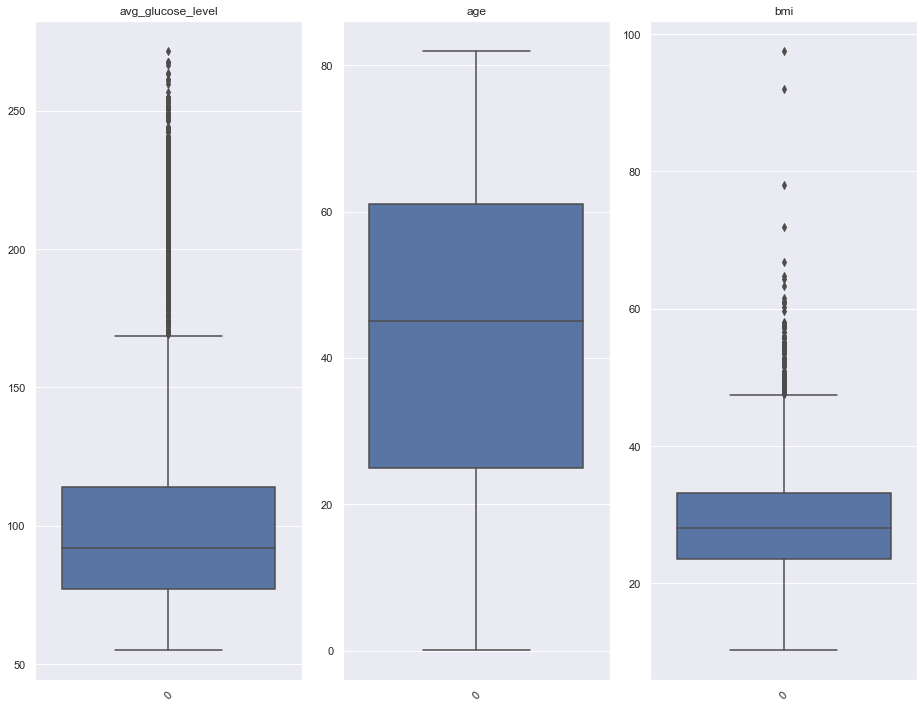

Figure 2: Boxplots of the numerical data


In [159]:
dataset_for_boxplot = whole_dataset[["avg_glucose_level", "age", "bmi"]]
x = 0
y = 0
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(1, 3, figsize=(13, 10))
for i in range(
    len(list(dataset_for_boxplot))
):  # because index for the subplots is needed
    column_name = list(dataset_for_boxplot)[i]
    sns.boxplot(data=dataset_for_boxplot[column_name], ax=ax[x])
    ax[x].set_xticklabels(ax[x].get_xticklabels(), rotation=45)
    ax[x].set_title(column_name)
    x += 1
plt.tight_layout()
plt.show()

print("Figure 2: Boxplots of the numerical data")
del dataset_for_boxplot


## Training a Neural Network


I will first train a basic Neural Network to see how well a Neural Network will behave without fixing the issues in my data, like missing values and class imbalance. This model will likely not perform well, as my classes are hugely imbalanced, so the model will be able to achieve a big accuracy score with always guessing one label.
The code below closely follows the tutorial https://www.tensorflow.org/tutorials/structured_data/imbalanced_data, as this tutorial also trains a binary classification model on imbalanced data.

### Data preprocessing

Since some columns in the data are categorical instead of numerical, the values should be changed to numerical values. The code to change the categorical values from strings to numerical values was taken from https://www.kaggle.com/arjunbhaybhang/stroke-prediction-using-svm-with-eda. The values are casted to numerical values to be sure they are fit for the model and the missing values are filled with 0 for now. This will be adjusted later on. 

In [160]:
def make_numerical(initial_dataset):
    pp_dataset = initial_dataset.copy()
    pp_dataset["gender"] = (
        pp_dataset["gender"]
        .replace({"Male": 0, "Female": 1, "Other": -1})
        .astype(np.uint8)
    )
    pp_dataset["Residence_type"] = (
        pp_dataset["Residence_type"].replace({"Rural": 0, "Urban": 1}).astype(np.uint8)
    )
    pp_dataset["work_type"] = (
        pp_dataset["work_type"]
        .replace(
            {
                "Private": 0,
                "Self-employed": 1,
                "Govt_job": 2,
                "children": -1,
                "Never_worked": -2,
            }
        )
        .astype(np.uint8)
    )
    pp_dataset["ever_married"] = (
        pp_dataset["ever_married"].replace({"Yes": 1, "No": 0}).astype(np.uint8)
    )
    pp_dataset["smoking_status"] = (
        pp_dataset["smoking_status"]
        .replace({"never smoked": 0, "Unknown": 1, "formerly smoked": 2, "smokes": -1})
        .astype(np.uint8)
    )
    return pp_dataset


In [161]:
pp_dataset = make_numerical(whole_dataset)
for column in pp_dataset:
    # filling NA with 0
    pp_dataset[column] = pd.to_numeric(pp_dataset[column], errors="coerce")
    pp_dataset[column] = pp_dataset[column].fillna(0)


The data is randomly split into a train, test and validation set.

In [162]:
from sklearn.model_selection import train_test_split
import numpy as np


def split(dataset):
    # Use a utility from sklearn to split and shuffle your dataset.
    train_df, test_df = train_test_split(dataset, test_size=0.2, random_state=0)
    train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=0)

    # Form np arrays of labels and features.
    train_labels = np.array(train_df.pop("stroke"))
    val_labels = np.array(val_df.pop("stroke"))
    test_labels = np.array(test_df.pop("stroke"))

    train_features = np.array(train_df)
    val_features = np.array(val_df)
    test_features = np.array(test_df)
    return {
        "train_labels": train_labels,
        "val_labels": val_labels,
        "test_labels": test_labels,
        "train_features": train_features,
        "val_features": val_features,
        "test_features": test_features,
    }


Because the data has a lot of outliers, the dataset is scaled using the Z-score.

In [163]:
from sklearn.preprocessing import StandardScaler


def scale_data(features_labels_dict):
    scaler = StandardScaler()
    train_features = scaler.fit_transform(features_labels_dict["train_features"])

    val_features = scaler.transform(features_labels_dict["val_features"])
    test_features = scaler.transform(features_labels_dict["test_features"])

    features_labels_dict["train_features"] = np.clip(train_features, -5, 5)
    features_labels_dict["val_features"] = np.clip(val_features, -5, 5)
    features_labels_dict["test_features"] = np.clip(test_features, -5, 5)

    print("Training labels shape:", features_labels_dict["train_labels"].shape)
    print("Validation labels shape:", features_labels_dict["val_labels"].shape)
    print("Test labels shape:", features_labels_dict["test_labels"].shape)

    print("Training features shape:", train_features.shape)
    print("Validation features shape:", val_features.shape)
    print("Test features shape:", test_features.shape)

    return features_labels_dict


In [164]:
features_labels_dict = split(pp_dataset)

features_labels_scaled_dict = scale_data(features_labels_dict)


Training labels shape: (3270,)
Validation labels shape: (818,)
Test labels shape: (1022,)
Training features shape: (3270, 10)
Validation features shape: (818, 10)
Test features shape: (1022, 10)


In [165]:
from tensorflow import keras

METRICS = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.AUC(name="prc", curve="PR"),  # precision-recall curve
]


def make_model(
    metrics=METRICS,
    output_bias=None,
    units=16,
    train_features=features_labels_scaled_dict["train_features"],
):
    set_random_seeds()

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential(
        [
            keras.layers.Dense(
                units, activation="relu", input_shape=(train_features.shape[-1],)
            ),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(
                1, activation="hard_sigmoid", bias_initializer=output_bias
            ),
        ]
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )

    return model


In [166]:
import tensorflow as tf


def train_model(model, features_labels_scaled_dict):
    set_random_seeds()

    EPOCHS = 9000  # large because early stopping is set up
    BATCH_SIZE = len(features_labels_scaled_dict["train_features"])

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        verbose=0,
        patience=10,
        mode="min",
        restore_best_weights=True,
    )
    history = model.fit(
        features_labels_scaled_dict["train_features"],
        features_labels_scaled_dict["train_labels"],
        verbose=0,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(
            features_labels_scaled_dict["val_features"],
            features_labels_scaled_dict["val_labels"],
        ),
    )
    return history, model, BATCH_SIZE


In [167]:
sm = SMOTE(random_state=2)

features_labels_scaled_dict["test_features"], features_labels_scaled_dict["test_labels"] = sm.fit_resample(features_labels_scaled_dict["test_features"], features_labels_scaled_dict["test_labels"].ravel())
features_labels_scaled_dict["val_features"], features_labels_scaled_dict["val_labels"] = sm.fit_resample(features_labels_scaled_dict["val_features"], features_labels_scaled_dict["val_labels"].ravel())


In [168]:
model = make_model()
history, trained_model, batch_size = train_model(model, features_labels_scaled_dict)


In [169]:
def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history["loss"], label="Train " + label)
    plt.semilogy(
        history.epoch, history.history["val_loss"], label="Val " + label, linestyle="--"
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("The loss of the model, shown per epoch")
    plt.show()


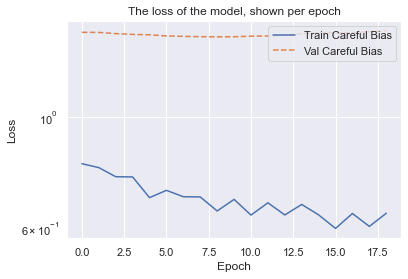

Figure 3: The loss as the model is training. Orange shows the validation bias and blue the train bias. The model has an early stopping measure set on validation bias.


In [170]:
plot_loss(history, "Careful Bias", 1)
print("Figure 3: The loss as the model is training. Orange shows the validation bias and blue the train bias. The model has an early stopping measure set on validation bias.")

In [171]:
def plot_metrics(history, no):
    metrics = ["loss", "prc", "precision", "recall"]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label="Train")
        plt.plot(
            history.epoch, history.history["val_" + metric], linestyle="--", label="Val"
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)

        plt.title(f"The {metric} as the model is training, shown per epoch")
        plt.legend()
        plt.tight_layout()
        plt.show()
        print(f"Figure {no+n}: Shown is the {metric} as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.")


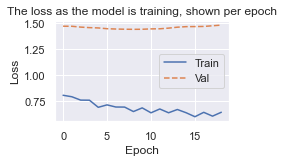

Figure 4: Shown is the loss as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.


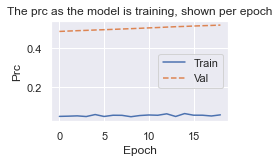

Figure 5: Shown is the prc as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.


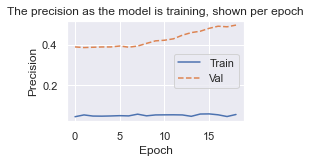

Figure 6: Shown is the precision as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.


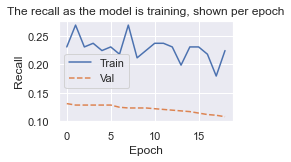

Figure 7: Shown is the recall as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.


In [172]:
plot_metrics(history, 4)


In [173]:
train_predictions = trained_model.predict(features_labels_scaled_dict["train_features"], batch_size=batch_size)
test_predictions = trained_model.predict(features_labels_scaled_dict["test_features"], batch_size=batch_size)

In [174]:
def plot_cm(labels, predictions, before_after, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        annot_kws={"fontsize": 15},
        yticklabels=["Actual no stroke", "Actual stroke"],
        xticklabels=["Predicted no stroke", "Predicted stroke"],
    )
    plt.title(f"Confusion matrix {before_after} oversampling at 16 units")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()



In [175]:
baseline_results_train = trained_model.evaluate(
    features_labels_scaled_dict["train_features"],
    features_labels_scaled_dict["train_labels"],
    batch_size=batch_size,
    verbose=0,
)
baseline_results_test = trained_model.evaluate(
    features_labels_scaled_dict["test_features"],
    features_labels_scaled_dict["test_labels"],
    batch_size=batch_size,
    verbose=0,
)
print("train")
for name, value in zip(trained_model.metrics_names, baseline_results_train):
    print(name, ": ", value)
print()

print("test")
for name, value in zip(trained_model.metrics_names, baseline_results_test):
    print(name, ": ", value)
print()



train
loss :  0.507378339767456
tp :  32.0
fp :  552.0
tn :  2562.0
fn :  124.0
accuracy :  0.7932721972465515
precision :  0.054794520139694214
recall :  0.20512820780277252
auc :  0.48600614070892334
prc :  0.05376666411757469

test
loss :  1.045584797859192
tp :  199.0
fp :  166.0
tn :  802.0
fn :  769.0
accuracy :  0.5170454382896423
precision :  0.5452054738998413
recall :  0.2055785059928894
auc :  0.4668829143047333
prc :  0.5235092043876648



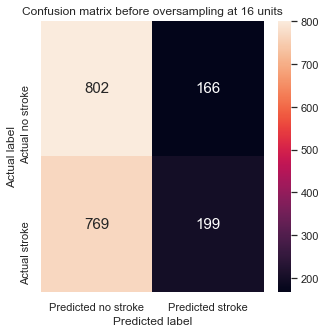

Figure 8: The confusion matrix of the model, made on the test dataset.


In [176]:
plot_cm(features_labels_scaled_dict["test_labels"], test_predictions, "before")
print("Figure 8: The confusion matrix of the model, made on the test dataset.")


In [177]:
def plot_roc(name, labels, predictions, auc, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100 * fp, 100 * tp, label=f"{name} (AUC = {auc})", linewidth=2, **kwargs)
    plt.xlabel("False positives [%]")
    plt.ylabel("True positives [%]")
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")


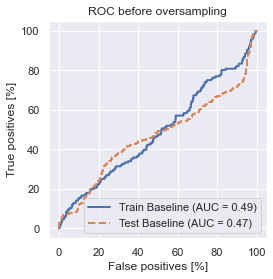

Figure 9: The ROC curve of the model, retrieved from the test set and the train set after the training process


In [178]:
plot_roc(
    "Train Baseline",
    features_labels_scaled_dict["train_labels"],
    train_predictions,
    round(baseline_results_train[8], 2),
)
plot_roc(
    "Test Baseline",
    features_labels_scaled_dict["test_labels"],
    test_predictions,
    round(baseline_results_test[8], 2),
    linestyle="--",
)
plt.legend(loc="lower right")
plt.title("ROC before oversampling")
plt.show()
print("Figure 9: The ROC curve of the model, retrieved from the test set and the train set after the training process")


# Bettering the performance

## Missing values

First I want to make a decision about what to do with the missing values in the BMI column. So I will investigate the rows where BMI is missing. 

In [179]:
dfna = whole_dataset[whole_dataset.isna().any(axis=1)]
dataset_prepocessing = whole_dataset.copy()


If the distributions of the set with missing BMI values and the whole dataset are equal, I'll assume I am not losing information by removing these values from the dataset. To test if the distributions are equal, I perform a two sample Kolmogorov-Smirnov test. This test is used to answer the question "What is the probability that this collection of samples could have been drawn from that probability distribution?". 

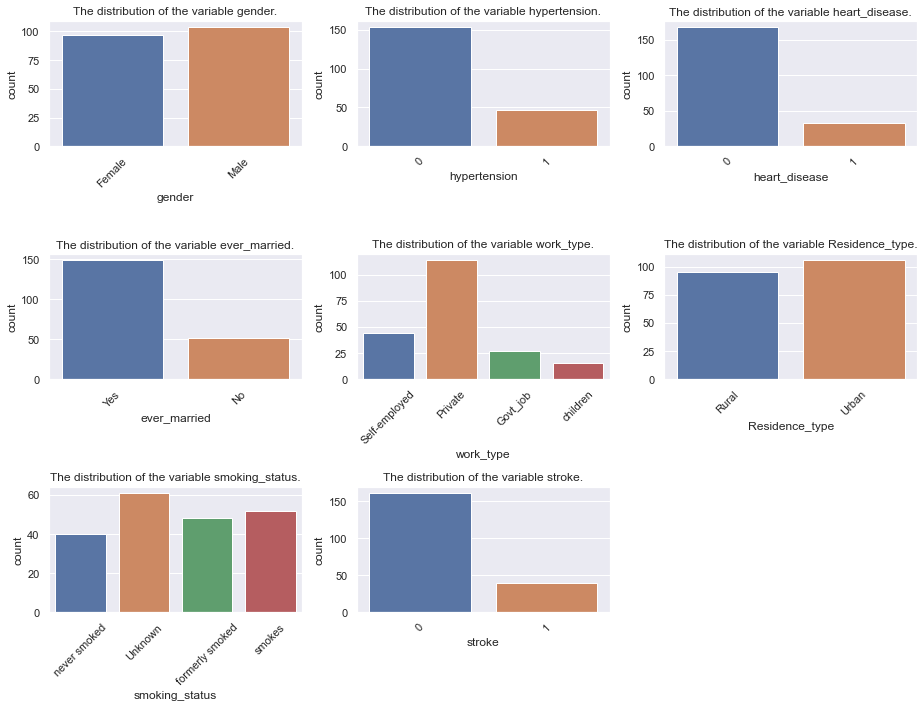

Figure 10: The distributions of the dataset after dropping the rows with empty values.


In [180]:
numerical = ["avg_glucose_level", "age", "bmi"]
dataset_for_viewing = dfna.drop(numerical, axis=1)  # These are not fit for a count plot
amount_columns = dataset_for_viewing.shape[1]
amount_plots_x_y = round(amount_columns / 2)
x = 0
y = 0
sns.set_theme(style="darkgrid")

fig, ax = plt.subplots(3, 3, figsize=(13, 10))
for i in range(
    len(list(dataset_for_viewing))
):  # # because index for the subplots is needed
    column_name = list(dataset_for_viewing)[i]
    sns.countplot(x=dataset_for_viewing[column_name], ax=ax[x, y])
    ax[x, y].set_xticklabels(ax[x, y].get_xticklabels(), rotation=45)
    ax[x, y].title.set_text(f"The distribution of the variable {column_name}.")
    if y == 2:
        y = 0
        x += 1
    else:
        y += 1

fig.delaxes(ax[2][2])
plt.tight_layout()
plt.show()

print("Figure 10: The distributions of the dataset after dropping the rows with empty values.")

In [181]:
stats_whole_dataset = whole_dataset.copy()
stats_whole_dataset = make_numerical(stats_whole_dataset)


In [182]:
dfna_stats = whole_dataset.copy()
dfna_stats.dropna()
dfna_stats = make_numerical(dfna_stats)


In [183]:
from scipy import stats

equals = []
for category in dfna_stats:
    test_results = stats.ks_2samp(dfna_stats[category], stats_whole_dataset[category])
    p_val = test_results[1]
    above_below = "above" if p_val > 0.05 else "below"
    equal_notequal = "equal" if p_val > 0.05 else "unequal"
    equals.append(equal_notequal)
    print(
        f"For category {category} the p-value is {p_val}. This is {above_below} our accepting score of 0.05. Therefore we conclude that the sets are of {equal_notequal} distribution."
    )

amount_equal = equals.count("unequal")
keep_discard = "keep" if amount_equal > 7 else "discard"
print(
    f"\nIn {amount_equal} out of {len(equals)} cases the distribution was not equal, so we decide to {keep_discard} the values."
)


For category gender the p-value is 1.0. This is above our accepting score of 0.05. Therefore we conclude that the sets are of equal distribution.
For category age the p-value is 1.0. This is above our accepting score of 0.05. Therefore we conclude that the sets are of equal distribution.
For category hypertension the p-value is 1.0. This is above our accepting score of 0.05. Therefore we conclude that the sets are of equal distribution.
For category heart_disease the p-value is 1.0. This is above our accepting score of 0.05. Therefore we conclude that the sets are of equal distribution.
For category ever_married the p-value is 1.0. This is above our accepting score of 0.05. Therefore we conclude that the sets are of equal distribution.
For category work_type the p-value is 1.0. This is above our accepting score of 0.05. Therefore we conclude that the sets are of equal distribution.
For category Residence_type the p-value is 1.0. This is above our accepting score of 0.05. Therefore we c

We decided to discard the rows with missing BMI values, as they are equal in distribution to the whole dataset.

In [184]:
dataset_prepocessing = dataset_prepocessing.dropna()


## Uneven distribution
As there are significantly more entries of people who have not suffered a stroke than there are who have, we need to even out the distribution to keep the model from always predicting the same label. However, the previously trained model only had 16 layers and DNNs are more suitable for unbalanced data, so I'll attempt to lower the FP rate by adding more layers first.

Training labels shape: (3141,)
Validation labels shape: (786,)
Test labels shape: (982,)
Training features shape: (3141, 10)
Validation features shape: (786, 10)
Test features shape: (982, 10)


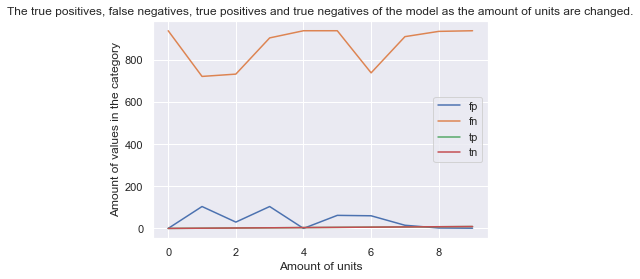

Figure 11: The true positives, false negatives, true positives and true negatives of the model as the amount of units are changed. The orange line shows the amount of false negatives, the blue line of the false positives, green of the true positives and red of the true negatives.


In [185]:
from sklearn.model_selection import train_test_split
import numpy as np

dataset_prepocessing = make_numerical(dataset_prepocessing)

features_labels_scaled_dict_2 = split(dataset_prepocessing)
features_labels_scaled_dict_2 = scale_data(features_labels_scaled_dict_2)


features_labels_scaled_dict_2["test_features"], features_labels_scaled_dict_2["test_labels"] = sm.fit_resample(features_labels_scaled_dict_2["test_features"], features_labels_scaled_dict_2["test_labels"].ravel())
features_labels_scaled_dict_2["val_features"], features_labels_scaled_dict_2["val_labels"], = sm.fit_resample(features_labels_scaled_dict_2["val_features"], features_labels_scaled_dict_2["val_labels"].ravel())


fp = []
fn = []
tp = []
tn = []


def find_metrics2(labels, predictions, p=0.5):
    # this one doesn't plot
    cm = confusion_matrix(labels, predictions > p)
    tn.append(cm[0][0])
    fp.append(cm[0][1])
    fn.append(cm[1][0])
    tp.append(cm[1][1])


for i in range(1, 100, 10):
    model = make_model(
        units=i, train_features=features_labels_scaled_dict_2["train_features"]
    )
    history, trained_model, BATCH_SIZE = train_model(
        model, features_labels_scaled_dict_2
    )
    baseline_results = trained_model.evaluate(
        features_labels_scaled_dict_2["test_features"],
        features_labels_scaled_dict_2["test_labels"],
        batch_size=BATCH_SIZE,
        verbose=0,
    )
    test_predictions = trained_model.predict(
        features_labels_scaled_dict_2["test_features"], batch_size=batch_size
    )

    find_metrics2(features_labels_scaled_dict_2["test_labels"], test_predictions)
    del history, trained_model, test_predictions


plt.plot(range(0, len(fp)), fp, label="fp")
plt.plot(range(0, len(fn)), fn, label="fn")
plt.plot(range(0, len(tp)), label="tp")
plt.plot(range(0, len(tn)), label="tn")
plt.xlabel("Amount of units")
plt.ylabel("Amount of values in the category")
plt.legend()
plt.title("The true positives, false negatives, true positives and true negatives of the model as the amount of units are changed.")
plt.show()
print("Figure 11: The true positives, false negatives, true positives and true negatives of the model as the amount of units are changed. The orange line shows the amount of false negatives, the blue line of the false positives, green of the true positives and red of the true negatives.")


As one can expect, the amount of false negatives increases as the amount of false positives decreases. This is because the model will classify input as positive more often. The amount of true positives and true negatives, however, remains relatively constant.

In [186]:
features_oversampled_dict = {}

before_1 = sum(features_labels_scaled_dict_2["train_labels"] == 1)
before_0 = sum(features_labels_scaled_dict_2["train_labels"] == 0)

print(f"Before OverSampling, counts of label '1': {before_1}")
print(f"Before OverSampling, counts of label '0': {before_0} \n")

sm = SMOTE(random_state=2)
features_oversampled_dict["train_features"], features_oversampled_dict["train_labels"] = sm.fit_resample(features_labels_scaled_dict_2["train_features"], features_labels_scaled_dict_2["train_labels"].ravel())
features_oversampled_dict["test_features"], features_oversampled_dict["test_labels"] = sm.fit_resample(features_labels_scaled_dict_2["test_features"], features_labels_scaled_dict_2["test_labels"].ravel())
features_oversampled_dict["val_features"], features_oversampled_dict["val_labels"] = sm.fit_resample(features_labels_scaled_dict_2["val_features"], features_labels_scaled_dict_2["val_labels"].ravel())

shape_train = features_oversampled_dict["train_features"].shape
shape_train_y = features_oversampled_dict["train_labels"].shape
print(f"After OverSampling, the shape of train_X: {shape_train}")
print(f"After OverSampling, the shape of train_y: {shape_train_y} \n")

after_1 = sum(features_oversampled_dict["train_labels"] == 1)
after_0 = sum(features_oversampled_dict["train_labels"] == 0)

print(f"After OverSampling, counts of label '1': {after_1}")
print(f"After OverSampling, counts of label '0': {after_0}")

print("train", len(features_oversampled_dict["train_features"]))
print("test", len(features_oversampled_dict["test_features"]))
print("val", len(features_oversampled_dict["val_features"]))

Before OverSampling, counts of label '1': 137
Before OverSampling, counts of label '0': 3004 

After OverSampling, the shape of train_X: (6008, 10)
After OverSampling, the shape of train_y: (6008,) 

After OverSampling, counts of label '1': 3004
After OverSampling, counts of label '0': 3004
train 6008
test 1878
val 1514


In [187]:
model = make_model(
    units=16, train_features=features_oversampled_dict["train_features"]
)
model.summary()
history_after, trained_model_after, BATCH_SIZE = train_model(
    model, features_oversampled_dict
)
print(
    features_oversampled_dict["test_features"], features_oversampled_dict["test_labels"]
)
baseline_results_train_after = trained_model_after.evaluate(
    features_oversampled_dict["train_features"],
    features_oversampled_dict["train_labels"],
    batch_size=BATCH_SIZE,
    verbose=0,
)
baseline_results_test_after = trained_model_after.evaluate(
    features_oversampled_dict["test_features"],
    features_oversampled_dict["test_labels"],
    batch_size=BATCH_SIZE,
    verbose=0,
)
test_predictions_after = trained_model_after.predict(
    features_oversampled_dict["test_features"], batch_size=BATCH_SIZE
)
train_predictions_after = trained_model_after.predict(
    features_oversampled_dict["train_features"], batch_size=BATCH_SIZE
)

print("train")
for name, value in zip(trained_model_after.metrics_names, baseline_results_train_after):
    print(name, ": ", value)
print()

print("test")
for name, value in zip(trained_model_after.metrics_names, baseline_results_test_after):
    print(name, ": ", value)
print()

find_metrics2(features_oversampled_dict["test_labels"], test_predictions_after)


Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_170 (Dense)            (None, 16)                176       
_________________________________________________________________
dropout_85 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 17        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
[[-0.14777833  0.28385063 -0.30852599 ... -0.77371165 -0.20302508
  -0.39511216]
 [-0.14777833 -0.11479792 -0.30852599 ...  0.90643953  0.1131008
   2.44532681]
 [ 0.07127393  1.39120774 -0.30852599 ...  3.35570127 -0.43063572
  -0.41756622]
 ...
 [-0.14777833  1.42313481 -0.30852599 ...  0.20122035 -0.22202957
  -0.402293  ]
 [ 0.07127393  1.67933631  3.24121806 ... -0.68883351 -0.

The same phenomonon as previously shown remains apparent. I would appear that the depth shown at point 15 is best, which is equal to 151.

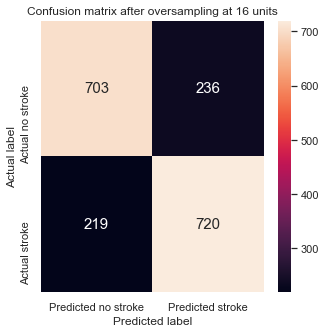

Figure 12: The confusion matrix of the model, made on the test dataset.


In [188]:
plot_cm(features_oversampled_dict["test_labels"], test_predictions_after, "after")
print("Figure 12: The confusion matrix of the model, made on the test dataset.")


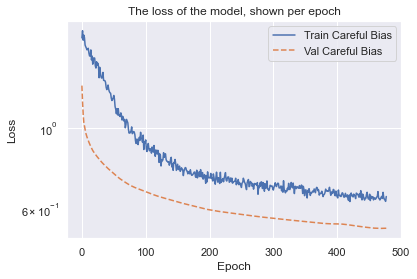

Figure 13: The loss as the model is training. Orange shows the validation bias and blue the train bias. The model has an early stopping measure set on validation bias.


In [189]:
plot_loss(history_after, "Careful Bias", 1)
print("Figure 13: The loss as the model is training. Orange shows the validation bias and blue the train bias. The model has an early stopping measure set on validation bias.")

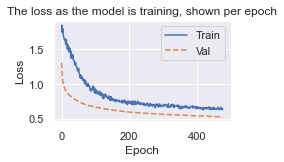

Figure 14: Shown is the loss as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.


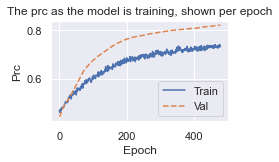

Figure 15: Shown is the prc as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.


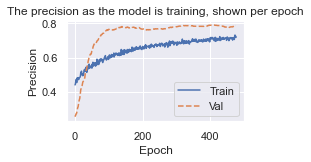

Figure 16: Shown is the precision as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.


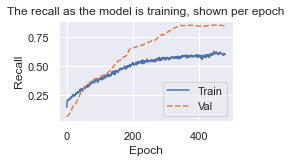

Figure 17: Shown is the recall as the model is training. It shown per epoch and the orange line shows the value of the validation set and the blue line of the train set.


In [190]:
plot_metrics(history_after, 14)


Figure 18: The ROC curve of the model, retrieved from the test set and the train set after the training process


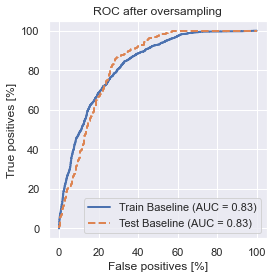

In [191]:
plot_roc(
    "Train Baseline",
    features_oversampled_dict["train_labels"],
    train_predictions_after,
    round(baseline_results_train_after[8], 2),
)
plot_roc(
    "Test Baseline",
    features_oversampled_dict["test_labels"],
    test_predictions_after,
    round(baseline_results_test_after[8], 2),
    linestyle="--",
)
plt.legend(loc="lower right")
plt.title("ROC after oversampling")
plt.show()
print("Figure 18: The ROC curve of the model, retrieved from the test set and the train set after the training process")
